# Simulation Results

As nice as all that mathematics was, it means nothing if this Bayes factor doesn't work as advertised. If it doesn't increase when a person plays with an unaltered copy of the game, and if it doesn't decrease when a cheater modifies their drop or barter rate, then it is useless no matter what the math tells us.

Modifying a copy of Minecraft 1.16.1 and doing speed runs is a time-consuming process, but we have a viable alternative: since the decision of whether to drop a Blaze rod or collection of Ender pearls is a Bernoulli process, it can be perfectly simulated by any other Bernoulli process. Pseudo-random number generators are a particularly good choice for this, as the probability of success can be controlled directly. We must still take care to match the behaviour of Minecraft speedrunners as closely as we can, of course.

In [1]:
# Execute this cell to install all dependencies locally
!pip -q install --user mpmath myst_nb numpy pandas matplotlib scipy

In [2]:
from fractions import Fraction

from math import log,factorial
import matplotlib.pyplot as plt
from mpmath import mp
from myst_nb import glue

import numpy as np

import pandas as pd
from scipy.optimize import differential_evolution
from scipy.stats import beta,binom,nbinom


dpi         = 200  # change this to increase/decrease the resolution charts are made at
book_output = True # changing this to False will make it easier to view plots in a Jupyter notebook

def fig_show( fig, name ):
    """A helper to control how we're displaying figures."""
    global book_output
    
    if book_output:
        glue( name, fig, display=False )
        plt.close();
    else:
        fig.show()

In [3]:
# missing "simple_bernoulli_bf.py"? Uncomment this line to grab it from the repository
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/simple_bernoulli_bf.py"

from simple_bernoulli_bf import prior, posterior_H_fair, BF_H_fair_H_cheat

## Blaze Rod Drops

Blaze rod drops are the easiest to model, as it almost certainly follows the Negative Binomial distribution. To try and match what actual speedrunners do, we'll load up all the data from the MST report and pool it together.

In [4]:
# missing the data files? Uncommenting and running this cell might retrieve them
# !mkdir data
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/blaze.benex.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/blaze.dream.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/blaze.illumina.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/blaze.sizzler.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/blaze.vadikus007.tsv"

In [5]:
# create a blank dataframe to store all this data in
all_blaze_rods = pd.DataFrame( {'n':[], 'k':[]} )


# the Ender pearl stats have slightly different names
blaze_players = ['benex','dream','illumina','sizzler','vadikus007']

# load in the data
for p in blaze_players:
    all_blaze_rods = all_blaze_rods.append( pd.read_csv(f'data/blaze.{p}.tsv',sep="\t") )

    
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')


# pull out all the unique values to be the X axis along our bar chart
blaze_k = sorted( all_blaze_rods['k'].unique() )
plt.bar( blaze_k, [all_blaze_rods['k'][ all_blaze_rods['k'] == k ].count() for k in blaze_k], \
        label='blaze rods gathered' )

plt.xlabel('blaze rods gathered')
plt.ylabel('number of runs where k rods were gathered')
plt.yticks([0,15,30])

fig_show( fig, 'fig:blaze_rods_gathered' )

```{glue:figure} fig:blaze_rods_gathered
:name: fig::blaze_rods_gathered

The number of Blaze rods gathered during runs from five separate top-level speedrunners, according to the Minecraft Speeedrunning Team.
```

(sec:blaze_rod_mechanics)=
### The Mechanics of Blaze Rods

There’s a surprising amount of variance in {ref}`the number of Blaze rods gathered <fig::blaze_rods_gathered>`, given the game mechanics involved.

Accessing The End requires finding a Stronghold, and finding that requires tossing Eyes of Ender to point out the direction of the Stronghold. Triangulating the location requires a minimum of two Eyes, and there’s a [one in five chance](https://minecraft.gamepedia.com/Eye_of_Ender#Locating_strongholds) an Eye will break when tossed. Once found, players must find [a portal](https://minecraft.gamepedia.com/End_Portal_Frame) within the Stronghold that grants them access to The End. This portal is powered by twelve Eyes of Ender, which have a one-in-ten chance of spontaneously appearing in an appropriate spot. Do the math, and the most common outcome is to have one Eye of Ender already in the portal, while three or more Eyes are present 34.1\% of the time. 

Eyes of Ender are crafted by combining Ender pearls with Blaze powder. Two items of the latter can be created from one Blaze rod. Given all of the above, the safest route is to kill Blazes until the runner has seven Blaze rods, which allows for fourteen Blaze powders and thus fourteen Eyes of Ender. Even if two Eyes of Ender break when finding the Stronghold, which has a 4\% chance of happening, the runner has enough Eyes to fill an empty portal.

While the safest route is indeed the most common one, a substantial number of speedruns collected only six rods. This is a viable route, as immediate entry to The End either requires no Eyes break while finding the stronghold (64\% odds), only one Eye breaks but the portal has at least one Eye already present (about 23\% odds), or both eyes break but two or more Eyes are present (about 1.4\%). Surprisingly, a number of runners also collected eight rods. This may be because the runner wasn’t confident they could find the Stronghold with just two Eyes and wanted some safety margin.

Five rods is the bare minimum I could see used to complete a speed run, as the odds of a runner with only eight Eyes of Ender keeping both the ones they toss and finding four or more in the End portal are only 1.6\%. The low-rod runs were likely aborted due to other reasons. That one run of ten rods comes from Benex, and [the comments](https://docs.google.com/spreadsheets/d/1P58S94yKB3Bm4A4_VotWyeelk_PvaTE1nDZx9DalEyk/edit#gid=1130044964) about going after Wither skeletons suggest it wasn't a typical speedrun. 

In real life, speed runners pick a range of Blaze rod targets, so our simulation should do the same. We’ll discard all the recorded runs where less than five and more than eight rods were collected, and use their relative frequencies to pick {glue:text}`sim_blaze_count` values for $k$. We’ll then create three universes: one where players with an unmodified game have $\vec k$ for Blaze rod targets, one where players boost their drop odds for the same targets, and one where players reduce their odds. Since one random simulation doesn’t give you a feel for the variation present, we’ll run {glue:text}`sim_blaze_clones` distinct players for each of the three scenarios just mentioned.

In [6]:
random  = np.random.default_rng(42)

# generate the weights and normalize
weights = np.array( [all_blaze_rods['k'][ all_blaze_rods['k'] == k ].count() for k in range(5,9)] )
weights = weights / np.sum(weights)

r_fair    = 0.5
r_cheat_h = 0.569 ; glue( 'sim_blaze_r_cheat_h', r_cheat_h*100, display=False )
r_cheat_l = 0.431 ; glue( 'sim_blaze_r_cheat_l', r_cheat_l*100, display=False )
count     = 200   ; glue( 'sim_blaze_count', count, display=False )
clones    = 16    ; glue( 'sim_blaze_clones', clones, display=False )
a_prior, b_prior   = prior(r_fair, 4)

x      = np.arange(1, count+1)
k      = 5 + random.choice( 4, size=(clones,count), p=weights )
sum_k  = np.cumsum( k, axis=1 )

cheat_h_nk = random.negative_binomial( k, r_cheat_h )
cheat_l_nk = random.negative_binomial( k, r_cheat_l )
fair_nk    = random.negative_binomial( k, r_fair )

sum_k         = np.cumsum( k, axis=1 )
sum_cheat_h_n = sum_k + np.cumsum( cheat_h_nk, axis=1 )
sum_cheat_l_n = sum_k + np.cumsum( cheat_l_nk, axis=1 )
sum_fair_n    = sum_k + np.cumsum( fair_nk, axis=1 )


fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

for idx in range(clones):
    y = [BF_H_fair_H_cheat(sum_k[idx][i], sum_cheat_h_n[idx][i], r_fair, a_prior, b_prior) for i in range(count)]
    if idx == 0:
        plt.plot( x, y, '-r', label=f'cheater (r={r_cheat_h:.3f})' )
    else:
        plt.plot( x, y, '-r', alpha=0.1 )

    y = [BF_H_fair_H_cheat(sum_k[idx][i], sum_cheat_l_n[idx][i], r_fair, a_prior, b_prior) for i in range(count)]
    if idx == 0:
        plt.plot( x, y, '-b', label=f'cheater (r={r_cheat_l:.3f})' )
    else:
        plt.plot( x, y, '-b', alpha=0.1 )

    y = [BF_H_fair_H_cheat(sum_k[idx][i], sum_fair_n[idx][i], r_fair, a_prior, b_prior) for i in range(count)]
    if idx == 0:
        plt.plot( x, y, '-k', label=f'fair (r={r_fair:.3f})' )
    else:
        plt.plot( x, y, '-k', alpha=0.1 )

plt.plot( x, [1 for v in x], '--g', label='break even' )

plt.xlabel("rounds")
plt.ylabel('H_fair / H_cheat')
plt.yscale("log")

plt.legend()
fig_show( fig, 'fig:sim_blaze_trio' )

```{glue:figure} fig:sim_blaze_trio 
:name: fig::sim_blaze_trio

The behaviour of this Bayes Factor for {glue:text}`sim_blaze_clones` clones of three players that had different Blaze rod drop rates. One group of {glue:text}`sim_blaze_clones` clones had the usual drop rate, one group increased it to {glue:text}`sim_blaze_r_cheat_h:.1f`\%, and one decreased it to {glue:text}`sim_blaze_r_cheat_l:.1f`\%
```

There are {ref}`two distinct behaviours <fig::sim_blaze_trio>`. For players with unmodified drop rates, the Bayes factor usually stays above one and appears to shadow the $\sqrt{n}$ trajectory detailed earlier. For the two cheating players, the Bayes factor gradually drifts below one and in some cases gets below 1:1,000,000 odds of playing fair. There’s a bit of variation, though, as one of the fair players' Bayes factors drifts downward toward the 1:1 odds range, and one of the cheaters manages roughly 1:1 odds of fair play during the entire session. There are also times where the cheating players have Bayes factors that suggest fair play, those these usually only happen during the first rounds.

Interestingly, the cheater that reduced their odds of a Blaze rod drop seems to have fared worse than the player that boosted their Blaze rod drops. One explanation is that while the Negative Binomial may be treated the same as the Binomial in the long run, always stopping on a positive will skew the results in the short term.

(sec:cheating_techniques)=
## Cheating Techniques

Why would a cheater want to reduce the number of Blaze rods they collect? Put yourself behind their keyboard. They know that the odds of being detected are high if they simply increase their drop rate. Someone watching the stream will get suspicious, count up Blaze rods, and alert others. 

A big-brained alternative is to *temporarily* elevate the drop rate. We're used to thinking of people getting lucky from time to time, so a short run of unusually good luck might pass under the radar. Even if it doesn't, the cheater has a plausible excuse. They can train during the sessions with the fair drop rate, and only start cheating when they’re skilled enough to earn a record.

One problem: for them, it will always be true that $\|\vec k\|_1 > r_\text{fair}\|\vec n\|_1$. No one may be able to detect their cheating in the short term, but a career-long analysis will show an elevated success rate relative to non-cheating players. The more times this cheater temporarily boosts their luck, the greater the evidence they've done exactly that.

A galaxy-brained move is to alternate between short periods of elevated drop rates and long periods of *deflated* drop rates. The PE report considers multiple "boost rates" for Ender pearl barters, but never considers deflated rates. The MST report states that apparently elevated drop rates made the speedrunning community suspicious of Dream (pg. 3), and that any runner "observed experiencing such unlikely events would be held to the same level of scrutiny" (pg. 4); the flip side is that any runner experiencing an unusually low number of drops would not. This blind spot of the speedrunning community could be exploited: by altering their drop rate both up and down, a cheating speedrunner can ensure their career stats do not reveal evidence of cheating. 

Greatly reducing their drop rate creates a large handicap to overcome, even if it does mean they can punch the “cheat” button pretty often. Instead, long periods of slightly-decreased luck would reduce the handicap and allow the cheater to exploit unusually good luck during their grind times. Should one of their elevated periods raise suspicion, not only can they pull out the "I got lucky" excuse, they can also point to a specific period of prior attempts and argue that, when taken as a whole, all the evidence demonstrates their drop rate is normal. The PE report analyzed the six attempts the MST report did for evidence of elevated drop rates, as well as those six plus five attempts Dream catalogued, but never considered analyzing those five attempts in isolation.

```{margin} One or Two tails?
{ref}`sec:p_value_misunderstood` mentioned that p-values have a problem with the definition of "extreme." Say I assert that a coin is biased by being more likely to come up heads than tails. I toss the coin, and get far more tails than heads. Depending on where you place the emphasis, I've either proven my assertion to be correct or incorrect. Worse, since the line for "extreme" is further from the centre with a two-tailed test verses a one-tailed test, researchers have a bit of "tilt" to shift values near that line to the side of their choosing. Worse still, there are no unambiguous standards for which type of p-value to use.{cite}`doi:10.3102/0013189X020009013`
``` 

To be clear, I'm not accusing Dream of either type of cheating. I've deliberately avoided doing the appropriate analysis before writing this text, in fact. When analyzing both reports for flaws, though, this oversight is easy to spot. It is also easy to detect, once you know what to look for, and the Bayes factor I've created is sensitive to both increased and decreased drop rates. An analysis that uses p-values might also be able to detect this if a "two-tailed" p-value is used, but the MST report opted to use a "one-tailed" p-value instead.

(sec:ender_pearl_barters)=
## Ender Pearl Barters

This analysis has focused on Blaze rods drops because they are so easy to understand. They can be directly analogized to the flip of a coin, and quite clearly follow a Negative Binomial, so the choice of simulation is very clear. None of the above math assumed a fifty-fifty success rate, nor whether the numbers were better modelled by the Negative Binomial or Binomial distributions. It should work flawlessly with Ender pearl barters.

Our simulation, on the other hand, must choose between the Negative Binomial or Binomial.

In [7]:
# missing the data files? Uncommenting and running this cell might retrieve them
# !mkdir data
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/bartering.benex.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/bartering.dream_before.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/bartering.dream_after.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/bartering.illumina.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/bartering.sizzler.tsv"
# !wget -P data "https://raw.githubusercontent.com/hjhornbeck/bayes_speedrun_cheating/main/data/bartering.vadikus007.tsv"

In [8]:
# create a blank dataframe to ensure the proper format
all_pearl_barters = pd.DataFrame( {'n':[], 'k':[]} )


# the Blaze rod stats have slightly different names
pearl_players = ['benex','dream_before','dream_after','illumina','sizzler','vadikus007']

# load in the data
for p in pearl_players:
    all_pearl_barters = all_pearl_barters.append( pd.read_csv(f'data/bartering.{p}.tsv',sep="\t") )

  
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

# pull out all the unique values for the X axis
pearl_k = sorted( all_pearl_barters['k'].unique() )
plt.bar( pearl_k, [all_pearl_barters['k'][ all_pearl_barters['k'] == k ].count() for k in pearl_k], \
        label='ender pearl barters' )

plt.xlabel('successful barters')
plt.ylabel('number of runs where k barters were successful')
plt.yticks([0,25,50])

fig_show( fig, 'fig:ender_pearl_barter' )

```{glue:figure} fig:ender_pearl_barter
:name: fig::ender_pearl_barter

The number of Ender pearl barters performed during a speedrun, according to the Minecraft Speeedrunning Team.
```

In {ref}`sec:nbinom_overuse`, I gave a theoretical argument for why Ender pearl barters may not follow a Negative Binomial distribution. Now we have {ref}`an empirical argument <fig::ender_pearl_barter>`. Bartering with Piglins is supposed to be the primary way to earn Ender pearls in a random-seed any-percent Minecraft 1.16 speedrun, and yet most speed runners earned zero Ender pearls via this method? 

The easiest explanation is that few of the runs in the MST report were successful. Players usually target a specific number of Ender pearls, but barters drop anywhere from four to eight pearls. Assuming uniform odds, two Ender pearl barters have a 60\% chance of giving twelve or more pearls, and as long as none of the resulting Eyes of Ender break while finding the Stronghold the runner can immediately go to The End. Half the time, it takes anywhere from two to thirty-five barters for a speed runner to earn two Ender pearl barters. Conversely, this means that half the time a player will have to wait longer than three and a half minutes to earn those barters, a serious problem if you are on the clock. If we assume that Minecraft 1.16 runners always target two barters, then only a quarter of all speed runs are successful. If players only stop bartering if they are out of time or earn those two barters, then that success rate implies they budget for twenty barters, which requires exactly two minutes to complete, and abort if they fail to hit that target.

Of course, that assumes quite a bit. Endermen have a fifty-fifty chance of dropping an Ender pearl when killed. While they rarely spawn in most Minecraft biomes, one notable exception is Nether Warped forest. A player that happens to stumble on such a biome can use that instead to gather Ender pearls. Barters also require gold ingots, so it is also possible for a speed runner to abort if they run out of gold instead of time. Theoretically, it's also possible to get to The End with just one Ender pearl barter. There’s a 20\% chance of getting eight Ender pearls at once and a 50\% chance of picking up two more via killing two to three Enderman, which gives the runner a 25\% chance of jumping immediately to The End once they’ve found the Stronghold. The overall odds of that happening are about 2.5\%, but a speedrunner may prefer the extra practice instead of aborting immediately.

Nonetheless, this gives us a prediction: if time or gold is more likely to be the stopping criteria than the number of successful Ender pearl barters, and both are correlated to $n$ rather than $k$, then charting the data with $n$ on the X axis should reveal a cutoff value for $n$.

In [9]:
r_pearl = 20/423

# pull out all the unique values
pearl_n = all_pearl_barters['n'].unique()
x       = np.arange(int(max( pearl_n )))

# separate these so we can scale the negative binomial appropriately
pearl_y   = [all_pearl_barters['n'][ \
                                    (all_pearl_barters['n'] == n) & (all_pearl_barters['k'] < 3) ].count() \
             for n in pearl_n]
nbinom2_y = nbinom( 2, r_pearl ).pmf( x )
nbinom2_y = nbinom2_y / np.max(nbinom2_y) * np.max(pearl_y)

fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

plt.bar( pearl_n, pearl_y, label='Ender pearl barters' )
plt.plot( x + 2, nbinom2_y, '-k', label='Negative Binomial, k=2', alpha=0.3 )

plt.xlabel('number of barters')
plt.ylabel('number of runs with n barters')
plt.yticks([0,3,9])

plt.legend()
fig_show( fig, 'fig:barters' )

```{glue:figure} fig:barters
:name: fig::barters

The number of barters performed during a speedrun, for sessions that had zero to two successful barters, according to the Minecraft Speeedrunning Team.
```

The data does show a bit of a cliff at the $n = 20$ mark, but it's more of a mesa with tonnes of debris at the base. There isn't a hard stopping time, it looks more like players trail off after that time.

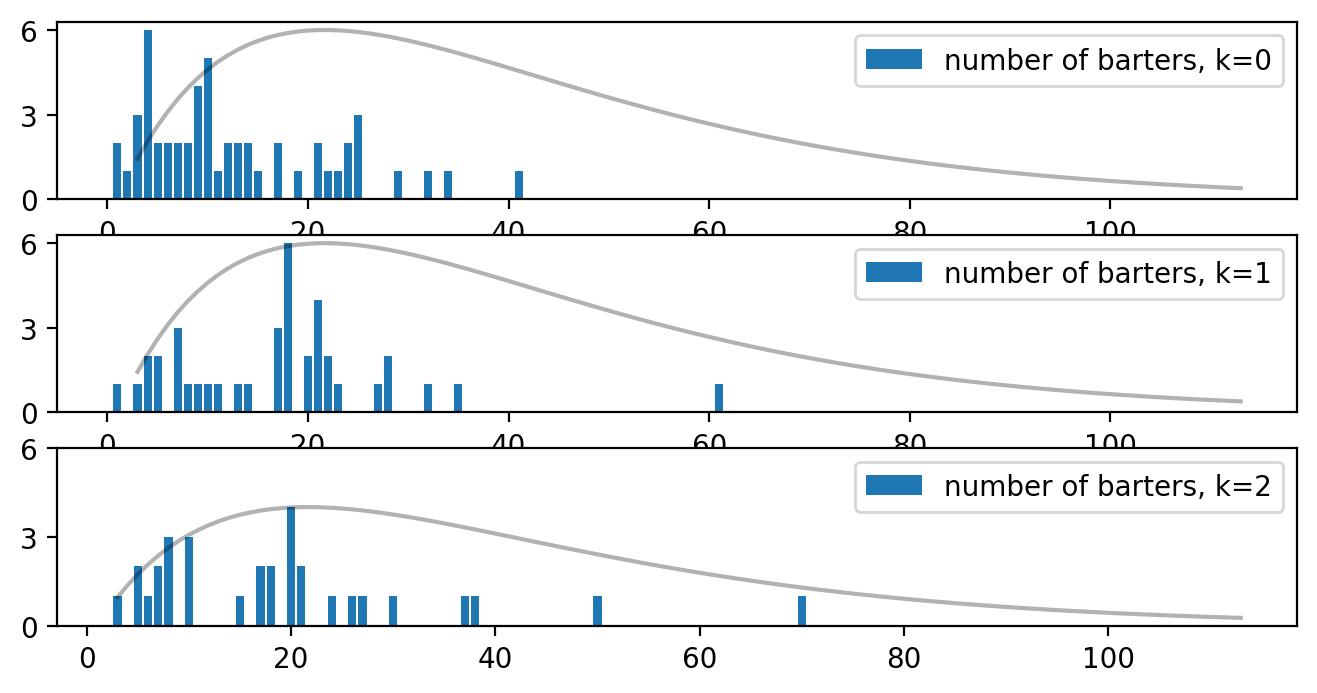

In [10]:
r_pearl = 20/423

x       = np.arange(1,int(all_pearl_barters['n'].max()))

# separate these so we can scale the negative binomial appropriately
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')
axs = fig.subplots(3, 1)

for k in range(3):
    mask = all_pearl_barters['k'] == k
    pearl_x = all_pearl_barters[ mask ]['n'].unique()
    pearl_y = [all_pearl_barters[ mask & (all_pearl_barters['n'] == n) ]['n'].count() for n in pearl_x]
    
    axs[k].bar( pearl_x, pearl_y, label=f'number of barters, k={k}' )
    
    nbinom_y = nbinom(2, r_pearl).pmf( x )
    axs[k].plot( x+2, nbinom_y/np.max(nbinom_y)*np.max(pearl_y), '-k', alpha=0.3 )

    axs[k].set_yticks([0,3,6])
    axs[k].legend()

    # axs[k].set_xlabel(f'number of barters, k={k}')
    
# plt.ylabel('number of runs with n barters')
# plt.yticks([0,3,9])

# plt.legend()
plt.show()

In [ ]:
random  = np.random.default_rng(64)

r_fair    = 20/423
r_cheat_h = 30/423 ; glue( 'sim_pearl_r_cheat_h', r_cheat_h*100, display=False )
count     = 300   ; glue( 'sim_pearl_count', count, display=False )
clones    = 16    ; glue( 'sim_pearl_clones', clones, display=False )
a_prior, b_prior   = prior(r_fair, 4)

choices_n = np.array( all_pearl_barters[all_pearl_barters['k'] < 3]['n'].unique(), dtype='int64' )
weights_n = [all_pearl_barters[(all_pearl_barters['k'] < 3) & (all_pearl_barters['n'] == n)]['n'].count() \
              for n in choices_n]
weights_n = weights_n / np.sum(weights_n)

vec_cheat_n_binom = random.choice( choices_n, p=weights_n, size=(clones,count) )
vec_cheat_k_binom = random.binomial( vec_cheat_n_binom, r_cheat_h )
vec_cheat_n_nbinom = random.negative_binomial( 2, r_cheat_h, size=(clones,count) ) + 2

mask = vec_cheat_n_nbinom < vec_cheat_n_binom
vec_cheat_k = 2*mask + vec_cheat_k_binom*(1-mask)
vec_cheat_n = np.minimum( vec_cheat_n_nbinom, vec_cheat_n_binom )

vec_fair_n_binom = random.choice( choices_n, p=weights_n, size=(clones,count) )
vec_fair_k_binom = random.binomial( vec_fair_n_binom, r_fair )
vec_fair_n_nbinom = random.negative_binomial( 2, r_fair, size=(clones,count) ) + 2

mask = vec_fair_n_nbinom < vec_fair_n_binom
vec_fair_k = 2*mask + vec_fair_k_binom*(1-mask)
vec_fair_n = np.minimum( vec_fair_n_nbinom, vec_fair_n_binom )

sum_fair_k = np.cumsum( vec_fair_k, axis=1 )
sum_fair_n = np.cumsum( vec_fair_n, axis=1 )

sum_cheat_k = np.cumsum( vec_cheat_k, axis=1 )
sum_cheat_n = np.cumsum( vec_cheat_n, axis=1 )


fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

x = np.arange(1,count+1)
for idx in range(clones):
    y = [BF_H_fair_H_cheat(sum_cheat_k[idx][i], sum_cheat_n[idx][i], r_fair, a_prior, b_prior) for i in range(count)]
    if idx == 0:
        plt.plot( x, y, '-r', label=f'cheater (r={r_cheat_h:.3f})' )
    else:
        plt.plot( x, y, '-r', alpha=0.1 )

    y = [BF_H_fair_H_cheat(sum_fair_k[idx][i], sum_fair_n[idx][i], r_fair, a_prior, b_prior) for i in range(count)]
    if idx == 0:
        plt.plot( x, y, '-k', label=f'fair (r={r_fair:.3f})' )
    else:
        plt.plot( x, y, '-k', alpha=0.1 )

plt.plot( x, [1 for v in x], '--g', label='break even' )

plt.xlabel("rounds")
plt.ylabel('H_fair / H_cheat')
plt.yscale("log")

plt.legend()
plt.show()
# fig_show( fig, 'fig:sim_pearl_duo' )

If Ender pearl barters followed a Negative Binomial, we'd expect the observed $n$ to follow a specific pattern. As Figure \ref{fig:ender_pearl_barter} shows, for the most part they do not. It's plausible that some of the data could be explained by a linear combination of the $k=1$ and $k=2$ cases, but the lack of barters at $10 < n < 17$ and $n > 25$ cannot. We'll use the observed distribution of $n < 55$ to generate values for $n$ and draw $k$ according to the appropriate probabilities. For the cheating case, we'll use $\frac 3 2 r_\text{fair} = \frac{30}{423}$.

In [1]:
random  = np.random.default_rng(64)

vec_k = np.array( [2] * 8 )

weights = {int(n):all_pearl_barters[all_pearl_barters['n'] == n]['n'].count() \
           for n in all_pearl_barters['n'].unique() if n > 20}
total = sum( weights[n] for n in weights )
vec_n = random.choice( list(weights.keys()), p=[weights[n]/total for n in weights.keys()], size=8 )
print(vec_k)
print(vec_n)
vec_r = random.negative_binomial(vec_k, 20/423)
print(vec_r)

def safe_binom( n, p, max_k = 2 ):
    k = random.binomial( n, p )
    while k >= max_k:
        k = random.binomial( n, p )
    return k

new_combo = [(vec_k[i], vec_r[i] + vec_k[i]) if vec_r[i] + vec_k[i] < vec_n[i] \
             else (safe_binom(vec_n[i], 20/423, vec_k[i]), vec_n[i]) for i,_ in enumerate(vec_n)]
vec_k, vec_n = zip(*new_combo)
print(vec_k)
print(vec_n)

NameError: name 'np' is not defined

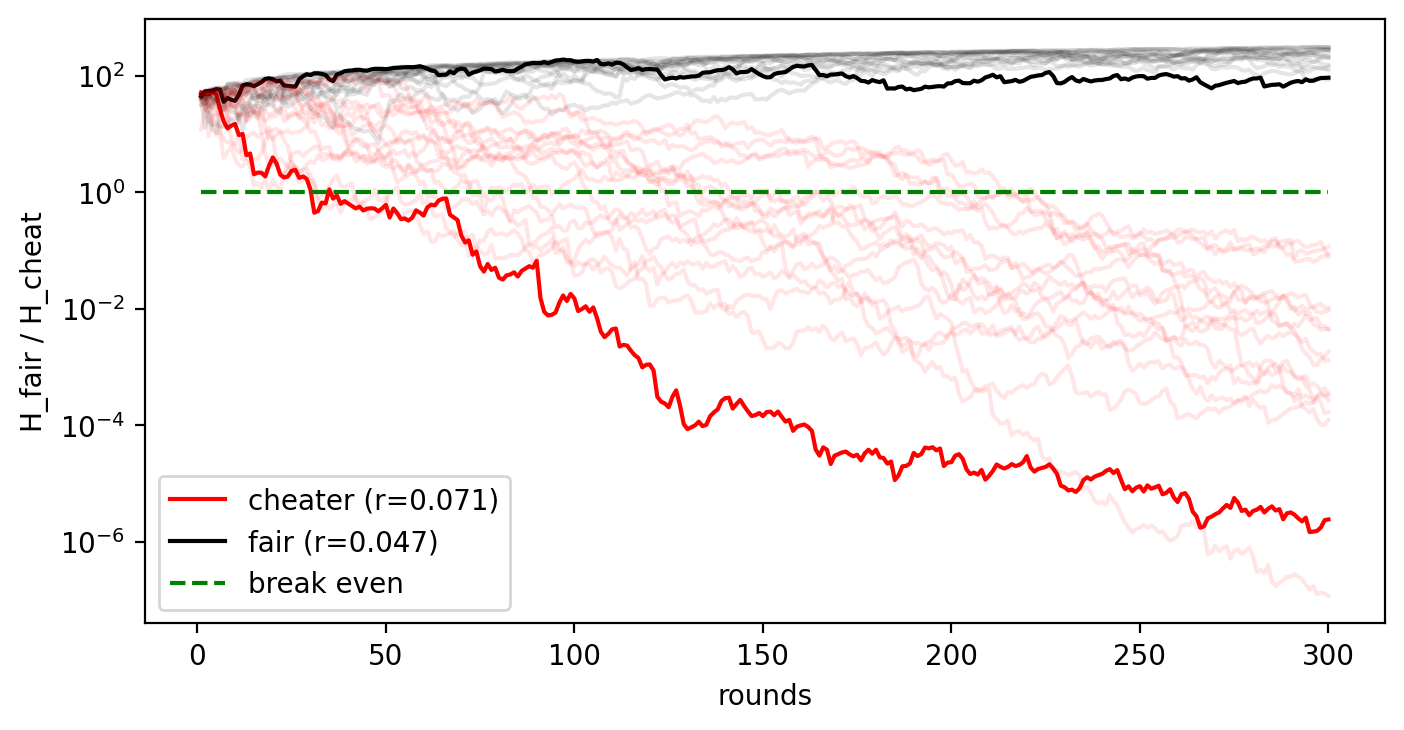

In [23]:
random  = np.random.default_rng(64)

r_fair    = r_pearl
r_cheat_h = r_pearl * 1.5
count     = 300
clones    = 16
a_prior, b_prior   = prior(r_fair, 4)

# build the distribution for n
mask    = all_pearl_barters['n'] < 55
pearl_n = sorted( all_pearl_barters['n'][mask].unique() )
weights = np.array([all_pearl_barters['n'][ all_pearl_barters['n'] == n ].count() for n in pearl_n])
pearl_s = np.sum( weights )
weights = weights / pearl_s

x      = np.arange(1, count+1)
n      = np.array(random.choice( pearl_n, size=(clones,count), p=weights ), dtype='int64')
sum_n  = np.cumsum( n, axis=1 )

cheat_h_k = np.cumsum( random.binomial( n, r_cheat_h ), axis=1 )
fair_k    = np.cumsum( random.binomial( n, r_fair ), axis=1 )


fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

for idx in range(clones):
    y = [BF_H_fair_H_cheat(cheat_h_k[idx][i], sum_n[idx][i], r_fair, a_prior, b_prior) for i in range(count)]
    if idx == 0:
        plt.plot( x, y, '-r', label=f'cheater (r={r_cheat_h:.3f})' )
    else:
        plt.plot( x, y, '-r', alpha=0.1 )

    y = [BF_H_fair_H_cheat(fair_k[idx][i], sum_n[idx][i], r_fair, a_prior, b_prior) for i in range(count)]
    if idx == 0:
        plt.plot( x, y, '-k', label=f'fair (r={r_fair:.3f})' )
    else:
        plt.plot( x, y, '-k', alpha=0.1 )

plt.plot( x, [1 for v in x], '--g', label='break even' )

plt.xlabel("rounds")
plt.ylabel('H_fair / H_cheat')
plt.yscale("log")

plt.legend()
plt.show()

Figure \ref{fig:sim_pearl_trio} has the same general trends as Figure \ref{fig:sim_blaze_trio}. It is more reluctant to accumulate evidence for $H_\text{cheat}$, which matches intuition. It is difficult to determine the rate of rare events, and by extension it must be difficult to determine the rate of a rare event *not* occuring, otherwise we'd always calculate the latter instead of the former. Put mathematically, we'd expect the difficulty to be roughly proportional to $p(1-p)$, which has a maximum at $p = \frac 1 2 = r_\text{blaze}$. So despite $\frac{30}{423}:\frac{20}{423} > \frac{569}{500}$, the simulation behind Figure \ref{fig:sim_pearl_trio} had to add an extra hundred rounds to show a clean separation between the fair and cheating players. By luck, the highlighted players are outliers among their peers; still, the proposed Bayes factor performs well.